In [34]:
from binance.client import Client
from binance import ThreadedWebsocketManager
import binance as bn
import pandas as pd
import sys
from datetime import datetime, timedelta
import ta as ta
import numpy as np
import json
import sys
sys.path.append('/Users/jp/Desktop/Investment/utils')
import utils
import matplotlib.pyplot as plt

Task was destroyed but it is pending!
task: <Task pending name='Task-228' coro=<ReconnectingWebsocket._read_loop() done, defined at /Users/jp/opt/anaconda3/lib/python3.9/site-packages/binance/streams.py:122> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7fa7580b6a30>()]>>
Task was destroyed but it is pending!
task: <Task pending name='Task-42' coro=<ReconnectingWebsocket._read_loop() running at /Users/jp/opt/anaconda3/lib/python3.9/site-packages/binance/streams.py:130> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7fa7ba424610>()]>>
Task was destroyed but it is pending!
task: <Task pending name='Task-249' coro=<ReconnectingWebsocket._read_loop() running at /Users/jp/opt/anaconda3/lib/python3.9/site-packages/binance/streams.py:130> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7fa7aa20cbe0>()]>>


In [35]:
pd.set_option('display.max_rows', None)

In [36]:
class Long_macd_peak_simp_trader():
    
    """Class to perform live testing using Binance testnet stream of data
    """
    def __init__(self, symbol=None, units='0.0006', interval=None, ema_slow=None, ema_fast=None, ema_signal=None, sesion_end=None, testnet=None, duration_minutes=None):
        
        """Long_macd_trader class constructor
        :param interval: a string among the followings: ["1m", "3m", "5m", "15m", "30m", "1h", "2h", "4h", "6h", "8h", "12h", "1d", "3d", "1w", "1M"]
        :type interval: str.
        :param start: a string with the following format ""%Y-%m-%d-%H:%M" .i.e. "2022-01-29-20:00"
        :type start: str.
        :param end: a string with the following format ""%Y-%m-%d-%H:%M" .i.e. "2022-02-29-20:00"
        :type end: str.
        :position: initial position in the market. 1 for long (have the asset) 0 for neutral (dont have the asset)
        :position: integer
        :back_testing: set to True if backtesting is necessary
        """
        self.units = units
        self.symbol = symbol
        self.interval = interval
        self.ema_slow = ema_slow
        self.ema_fast = ema_fast
        self.ema_signal = ema_signal 
        self.testnet = testnet #if the sesion takes place in the testnet
        self.duration_minutes = duration_minutes # duration of the trading sesion in minutes
        self.run_end_time_utc = None
        self.run_end_delta = None
        self.data = pd.DataFrame()
        self.trades = 0 #counter of the number of trades
        self.trade_values = [] #all trading positions consecutive, long/short... or short/long...
        self.trade_values_time = [] #time at which each value in trade_values was appended
        self.position = None #initially no position is decided, it is pending to analysis recent data of macd to decide
                             #what is the best way to enter the market        self.tct = None #turned complete time
        self.client = None 
        self.trade_start_time_utc = None # time in utc to be defined when the stream of OHLC starts ( this time
        #is used to extract the difference between actual time of trading sesion in utc time and the index of the
        # last kandle data that it is given also in utc time by binance api)
        self.twm = None # Initialize ws client
        self.profit = None #Final profit at the end of the trading sesion where the latest position is neutral
        self.positive_peak_found = False
        self.negative_peak_found = False       
    
    def stream_candles(self, msg):
        event_time = pd.to_datetime(msg["E"], unit = "ms")
        start_time = pd.to_datetime(msg["k"]["t"], unit = "ms")
        first   = float(msg["k"]["o"])
        high    = float(msg["k"]["h"])
        low     = float(msg["k"]["l"])
        close   = float(msg["k"]["c"])
        volume  = float(msg["k"]["v"])
        complete=       msg["k"]["x"]
    
        # feed df (add new bar / update latest bar)
        self.data.loc[start_time, 'Open'] = first
        self.data.loc[start_time, 'High'] = high
        self.data.loc[start_time, 'Low'] = low
        self.data.loc[start_time, 'Close'] = close
        self.data.loc[start_time, 'Volume'] = volume
        self.data.loc[start_time, 'Complete'] = complete
        # add balance_ini column with the balance in the latest bar before executing order (after complete==True)
        self.data.loc[start_time, 'balance_ini'] = round(float(self.client.get_asset_balance(asset='USDT')['free']),3)
        # add balance_end column with the balance in the latest bar after executing order (after complete==True)
        self.data.loc[start_time, 'balance_end'] = np.nan
        # initialize quote_units
        self.data.loc[start_time, 'quote_units'] = np.nan
        #update MACD parameters with each ws retrieval
        macd_diff = ta.trend.MACD(close=self.data.Close, window_slow=self.ema_slow, window_fast=self.ema_fast, window_sign=self.ema_signal, fillna=False).macd_diff()
        macd_macd = ta.trend.MACD(close=self.data.Close, window_slow=self.ema_slow, window_fast=self.ema_fast, window_sign=self.ema_signal, fillna=False).macd()
        macd_signal = ta.trend.MACD(close=self.data.Close, window_slow=self.ema_slow, window_fast=self.ema_fast, window_sign=self.ema_signal, fillna=False).macd_signal()         
        self.data.loc[start_time, 'macd_diff'] = macd_diff.iloc[-1]
        self.data.loc[start_time, 'macd_macd'] = macd_macd.iloc[-1]
        self.data.loc[start_time, 'macd_signal'] = macd_signal.iloc[-1]
        
        #INTRODUCE SOME SORT OF EMERGENCY SELL DUE TO HIGH DROP IN PRICE IF WE ARE LONG.
        #IN THIS CASE IT IS NOT NECESSARY TO HAVE THE KANDLE COMPLETE TO EXECUTE THE MARKET SELL ORDER.
        
        
        
        #FEATURE:#
        #LOOK FOR THE OUTLIERS OF NEGATIVE RETURNS IN BTC
        
        
        #######
        
       
        # print out
        print(f"l_t: {event_time}|st: {start_time}|l_p: {format(self.data.Close[-1],'.2f')}|macdd: {format(self.data.macd_diff[-1],'.2f')}|p: {self.position} |c: {complete}")      
        
        # print out
#         print(".", end = "", flush = True) # just print something to get a feedback (everything OK)
        dt = datetime.utcnow() - self.trade_start_time_utc
        if ((dt) > timedelta(minutes=self.duration_minutes)):
            self.stop_ses()
        
        if (complete == True):
            self.tct = start_time #time of the lastest updated/incorporated kandle            
            self.define_strategy()
            self.execute_trades()
                
    def start_trading(self):
        self.trade_start_time_utc = datetime.utcnow()
        self.twm = ThreadedWebsocketManager()
        self.twm.start()
        self.prepare_recent_data()
        try:                  
            
            self.twm.start_kline_socket(callback = self.stream_candles, symbol = self.symbol, interval = self.interval)
        
        except (BinanceAPIException, ConnectionResetError, requests.exceptions.ConnectionError, requests.exceptions.RequestException) as e:
            print(e)
            print('Something went wrong. Error occured at %s. The sesions will be automatically stopped after GOING NEUTRAL.' % (datetime.now().astimezone(timezone.utc)))
            self.stop_ses()

    def stop_ses(self, save_to_file=True):

        self.run_end_time_utc = datetime.utcnow()
        dt = self.run_end_time_utc - self.trade_start_time_utc
        self.run_end_delta = round(dt.seconds/60,0)
        print(f"trading sesion duration = {self.run_end_delta} minutes up to {self.duration_minutes}")
        if self.position == 1:
            order = self.client.create_order(symbol = self.symbol, side = "SELL", type = "MARKET", quantity = self.units)
            self.report_trade(order, "GOING NEUTRAL AND STOP") 
            self.position = 0
        if self.position == None:
            if (len(self.trade_values) == 0):
                print("STOP BEFORE PLACING ORDERS")
            else:               
                if (self.trade_values[-1] < 0):
                    self.position = 0 # latest neutral position
                    li = self.data.index == self.data.index[-1]
                    self.data.loc[li, 'position'] = self.position 
                    order = self.client.create_order(symbol = self.symbol, side = "SELL", type = "MARKET", quantity = self.units)
                    self.report_trade(order, "GOING NEUTRAL AND STOP") 
                else:
                    print("STOP")
        self.twm.stop()
        
        if (save_to_file == True):
            self.profit = sum(self.trade_values)  
            trades_num_filter = self.data.position.dropna() != None
            trades_num = len(trades_num_filter)
            start_ses = datetime.strftime(self.trade_start_time_utc, "%Y-%m-%d-%H:%M")
            li = self.data.index == self.data.index[-1]
            self.data.loc[li, 'position'] = self.position
            self.data.to_csv(f"start_{start_ses}__duration_{self.run_end_delta}min_upto_{self.duration_minutes}min__profit_{self.profit}dollar__tradesnum_{trades_num}")        
    
    def define_strategy(self):
        self.stablish_positions()

    def execute_trades(self):
        #execute trades depending on the positions stablished in define_strategy()
            if self.position == 1:
                order = self.client.create_order(symbol = self.symbol, side = "BUY", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING LONG")

            if self.position == 0:
                order = self.client.create_order(symbol = self.symbol, side = "SELL", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING NEUTRAL")

            if self.position == None:
                pass
            
            cond_last = self.data.index == self.data.index[-1]
            self.data.loc[cond_last, 'balance_end'] = round(float(self.client.get_asset_balance(asset='USDT')['free']),3)
    
        
    def report_trade(self, order, going):
        last_index = self.data.index[-1]
        cond_last = self.data.index == self.data.index[-1]
        # extract data from order object
        side = order["side"]
        time = pd.to_datetime(order["transactTime"], unit = "ms")
        base_units = float(order["executedQty"])
        quote_units = float(order["cummulativeQuoteQty"])
        
        # calculate trading profits
        self.trades += 1
        
        last_t_str = datetime.strftime(self.data.index[-1], '%Y-%m-%d-%H:%M')
        
        if side == "BUY":
            self.trade_values.append(-quote_units)
            self.data.loc[cond_last, 'quote_units'] = -quote_units
        elif side == "SELL":
            self.trade_values.append(quote_units)
            self.data.loc[cond_last, 'quote_units'] = quote_units
          
        self.trade_values_time.append(last_t_str)

        if self.trades % 2 == 0:
            real_profit = round(np.sum(self.trade_values[-2:]), 3) 
            cum_profits = round(np.sum(self.trade_values), 3)
        else: 
            real_profit = 0
            cum_profits = round(np.sum(self.trade_values[:-1]), 3)
           
        # print trade report
        print(2 * "\n" + 100* "-")
        print("{} | {}".format(time, going)) 
        print("{} | Base_Units = {} | Quote_Units = {} | Price = {} ".format(time, base_units, quote_units, self.data.Close.iloc[-1]))
        print("{} | Real profit = {} | Accumulate profit = {} ".format(time, real_profit, cum_profits))
        print(100 * "-" + "\n")
        
    def prepare_recent_data(self):
        '''
        REMARK: Introduced time must be in Tokyo time (UTC+9) but the calculations will be in UTC
        Prepare all the fields of dat a necessary for the study. The interval of dates to be studied is the one
        given when delclaring the class. To prepare another interval of dates, please create another class instance.
        :param start: a string with the following format ""%Y-%m-%d-%H:%M" .i.e. "2022-01-29-20:00"
        :type start: str.
        :param end: a string with the following format ""%Y-%m-%d-%H:%M" .i.e. "2022-02-29-20:00"
        :type end: str.
        :param interval: string among the followings: ["1m", "3m", "5m", "15m", "30m", "1h", "2h", "4h", "6h", "8h", "12h", "1d", "3d", "1w", "1M"]
        :type interval: str.
        '''
        
        #Prepare pre-data to the present moment with non NaN for the trading period (macd paramters ready)
        current_time_obj = datetime.now()
        current_time = int(current_time_obj.timestamp()*1000)

#         from_time_obj = datetime.strptime(start, "%Y-%m-%d-%H:%M")
#       ["1m", "3m", "5m", "15m", "30m", "1h", "2h", "4h", "6h", "8h", "12h", "1d", "3d", "1w", "1M"]
        ema_diff = self.ema_slow + self.ema_signal + 2
        td = timedelta()
        if 'm' in self.interval:
            num_min = int(self.interval.replace('m',''))
            td = timedelta(minutes=num_min*(ema_diff))
        if 'h' in self.interval:
            num_h = int(self.interval.replace('h',''))
            td = timedelta(hours=num_h*(ema_diff))
        if 'd' in self.interval:
            num_day = int(self.interval.replace('d',''))
            td = timedelta(days=num_day*(ema_diff))
        if 'w' in self.interval:
            num_week = int(self.interval.replace('w',''))
            td = timedelta(weeks=num_week*(ema_diff))
        if 'M' in self.interval:
            num_week_m = int(self.interval.replace('M',''))
            td = timedelta(weeks=num_week_m * 4 * (ema_diff))
        from_time_obj = current_time_obj - td
        from_time = int((current_time_obj - td).timestamp()*1000)
        self.data, self.client = utils.get_history_v3(symbol=self.symbol, interval=self.interval, start=from_time, end=current_time, testnet=self.testnet)
        #obtaining MACD instance from python ta
        macd_diff = ta.trend.MACD(close=self.data.Close, window_slow=self.ema_slow, window_fast=self.ema_fast, window_sign=self.ema_signal, fillna=False).macd_diff()
        macd_macd = ta.trend.MACD(close=self.data.Close, window_slow=self.ema_slow, window_fast=self.ema_fast, window_sign=self.ema_signal, fillna=False).macd()
        macd_signal = ta.trend.MACD(close=self.data.Close, window_slow=self.ema_slow, window_fast=self.ema_fast, window_sign=self.ema_signal, fillna=False).macd_signal()
        #assigning the values of macd to ticker dataframe
        self.data['macd_diff'] = macd_diff
        self.data['macd_macd'] = macd_macd
        self.data['macd_signal'] = macd_signal
        #last candle retrieved from old data till the present moment will be incomplete 99.9% of the time
        self.data["Complete"] = [True for row in range(len(self.data)-1)] + [False]
        #decide position to be given to the latest recent data kandle (not completed in 99% of cases and that is 
        #going to be updated by the stream of data, so actually, position given to the latest kandle at this point
        #it is mots likely not to be used, but updated.
        self.stablish_positions()

    def stablish_positions(self):
        
        #stablish neutral conditions
        cond1 = self.data.macd_diff.iloc[-3] > 0
        cond2 = self.data.macd_diff.iloc[-2] > 0
        cond3 = self.data.macd_diff.iloc[-1] > 0
        cond4 = self.data.macd_diff.iloc[-2] > self.data.macd_diff.iloc[-1]
        cond5 = self.data.macd_diff.iloc[-2] > self.data.macd_diff.iloc[-3]
        cond_all_neutral = cond1&cond2&cond3&cond4&cond5
        
        #stablish buy conditions
        cond6 = self.data.macd_diff.iloc[-3] < 0
        cond7 = self.data.macd_diff.iloc[-2] < 0
        cond8 = self.data.macd_diff.iloc[-1] < 0
        cond9 = self.data.macd_diff.iloc[-2] < self.data.macd_diff.iloc[-1]
        cond10 = self.data.macd_diff.iloc[-2] < self.data.macd_diff.iloc[-3]
        cond_all_buy = cond6&cond7&cond8&cond9&cond10        
        
        if ((cond_all_neutral == True) and (self.negative_peak_found == False)):
            self.position = 0 #position adopted in the latest kandle that is incomplete 99% cases
            self.negative_peak_found = True
            self.positive_peak_found = False
            
        elif ((cond_all_buy == True) and (self.positive_peak_found == False)):
            self.position = 1 #position adopted in the latest kandle that is incomplete 99% cases
            self.positive_peak_found = True
            self.negative_peak_found = False
        else:  
            self.position = None #in any other case do nothing and continue
            
        li = self.data.index == self.data.index[-1]
        self.data.loc[li, 'position'] = self.position
    
    def open_orders(self):
        orders = self.client.get_open_orders(symbol=self.symbol)
        print(orders)
 
    def plot_results(self, start_plot=None, end_plot=None, width_bars=0.1):
        
        # from IPython.core.display import display, HTML
        # display(HTML("<style>.container { width:100% !important; }</style>"))
        colors=[]

        fig, (close_ax, macd_ax) = plt.subplots(nrows=2, ncols=1, figsize=(30,20), gridspec_kw={'height_ratios': [4,2]}, sharex=True)

        close_ax.grid(visible=True, which='major', axis='x', color='grey')
        macd_ax.grid(visible=True, which='major', axis='x', color='grey')
        close_ax.grid(visible=True, which='major', axis='y', color='grey')
        macd_ax.grid(visible=True, which='major', axis='y', color='grey')
        close_ax.grid(visible=True, which='minor', axis='x', color='grey')
        macd_ax.grid(visible=True, which='minor', axis='x', color='grey')

        close_ax.tick_params(labelrotation=45)
        macd_ax.tick_params(labelrotation=45)

        close_ax.margins(0)
        macd_ax.margins(0)
        
        close_ax.set_ylim(auto=True)
        
        data_ready = self.data.dropna(subset=['macd_diff', 'macd_macd', 'macd_signal']).copy()
        
        
        if (start_plot == None):
            start_plot = data_ready.index[0]
        if (end_plot == None):
            end_plot = data_ready.index[-1]  
            
        if ((start_plot != None) and (end_plot !=None)):
            cond_start = data_ready.index >= start_plot
            cond_end = data_ready.index <= end_plot
            data_ready = data_ready[cond_start&cond_end]
                
        for index, value in data_ready.macd_diff.iteritems():
            if value > 0:
                colors.append('g')
            else:
                colors.append('r')
                
        close_ax.plot(data_ready.index, data_ready.Close) #plot the data without shifting

        #shift one position the inv_sign only for plotting the signal in the day after is found, without shifting the
        #Close prices
        data_ready_shift = data_ready.copy()
        data_ready_shift['position'] = data_ready.position.shift(1)
        buy_pos = data_ready_shift.position == 1              
        buy_trade = data_ready_shift.loc[buy_pos]
        sell_pos = data_ready_shift.position == 0            
        sell_trade = data_ready_shift.loc[sell_pos]
        close_ax.scatter(sell_trade.index, sell_trade.Close.loc[sell_trade.index], marker='^', color='r', s=100)
        close_ax.scatter(buy_trade.index, buy_trade.Close.loc[buy_trade.index], marker='^', color='g', s=100)

        if ((self.data.Complete.iloc[-1] == False) and (self.data.position.iloc[-1] == 0)):
            close_ax.scatter(self.data.index[-1], self.data.Close.loc[self.data.index[-1]], marker='^', color='r', s=100)
        
        macd_ax.bar(x= data_ready.index, height= data_ready.macd_diff, width=width_bars, align='center', color=colors, edgecolor='black')

In [37]:
trader_peak_test = Long_macd_peak_simp_trader(symbol="BTCUSDT", units='0.005',interval='1m', ema_slow=25, ema_fast=12, ema_signal=25, testnet=True, duration_minutes=20)

In [43]:
trader_peak_test.start_trading()

52
l_t: 2022-10-14 11:06:51.593000|st: 2022-10-14 11:06:00|l_p: 19680.95|macdd: -1.11|p: None |c: False
l_t: 2022-10-14 11:06:53.600000|st: 2022-10-14 11:06:00|l_p: 19680.77|macdd: -1.13|p: None |c: False


In [39]:
#trader_peak_test.data

In [40]:
#trader_peak_test.trade_values

In [41]:
#trader_peak_test.data

In [45]:
trader_peak_test.stop_ses()

trading sesion duration = 0.0 minutes up to 20


----------------------------------------------------------------------------------------------------
2022-10-14 11:06:57.010000 | GOING NEUTRAL AND STOP
2022-10-14 11:06:57.010000 | Base_Units = 0.005 | Quote_Units = 98.3888 | Price = 19679.58 
2022-10-14 11:06:57.010000 | Real profit = 0 | Accumulate profit = -200 
----------------------------------------------------------------------------------------------------

l_t: 2022-10-14 11:06:58.055000|st: 2022-10-14 11:06:00|l_p: 19678.87|macdd: -1.26|p: 0 |c: False


In [22]:
trader_peak_test.client

In [23]:
trader_peak_test.data

,Open,High,Low,Close,Volume,macd_diff,macd_macd,macd_signal,Complete,position,balance_ini,balance_end,quote_units
Date,,,,,,,,,,,,,
2022-10-14 10:10:00,19722.18,19722.52,19698.76,19704.94,6.439480,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
2022-10-14 10:11:00,19704.19,19704.19,19673.50,19679.06,5.086022,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
2022-10-14 10:12:00,19678.87,19679.26,19666.33,19668.94,6.111435,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
2022-10-14 10:13:00,19668.60,19668.61,19658.98,19658.98,4.706340,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
2022-10-14 10:14:00,19658.98,19677.77,19656.85,19672.51,7.810827,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
2022-10-14 10:15:00,19671.96,19671.96,19639.91,19645.48,7.236778,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
2022-10-14 10:16:00,19649.31,19662.77,19648.19,19655.76,6.011144,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
2022-10-14 10:17:00,19655.76,19679.13,19655.19,19672.23,7.690830,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
2022-10-14 10:18:00,19671.62,19679.17,19670.95,19671.32,6.148814,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN


In [44]:
trader_peak_test.trade_values.append(-200)

l_t: 2022-10-14 11:06:55.775000|st: 2022-10-14 11:06:00|l_p: 19679.58|macdd: -1.21|p: None |c: False


In [27]:
trader_peak_test.twm.stop()

l_t: 2022-10-14 11:03:18.284000|st: 2022-10-14 11:03:00|l_p: 19691.09|macdd: 1.26|p: None |c: False


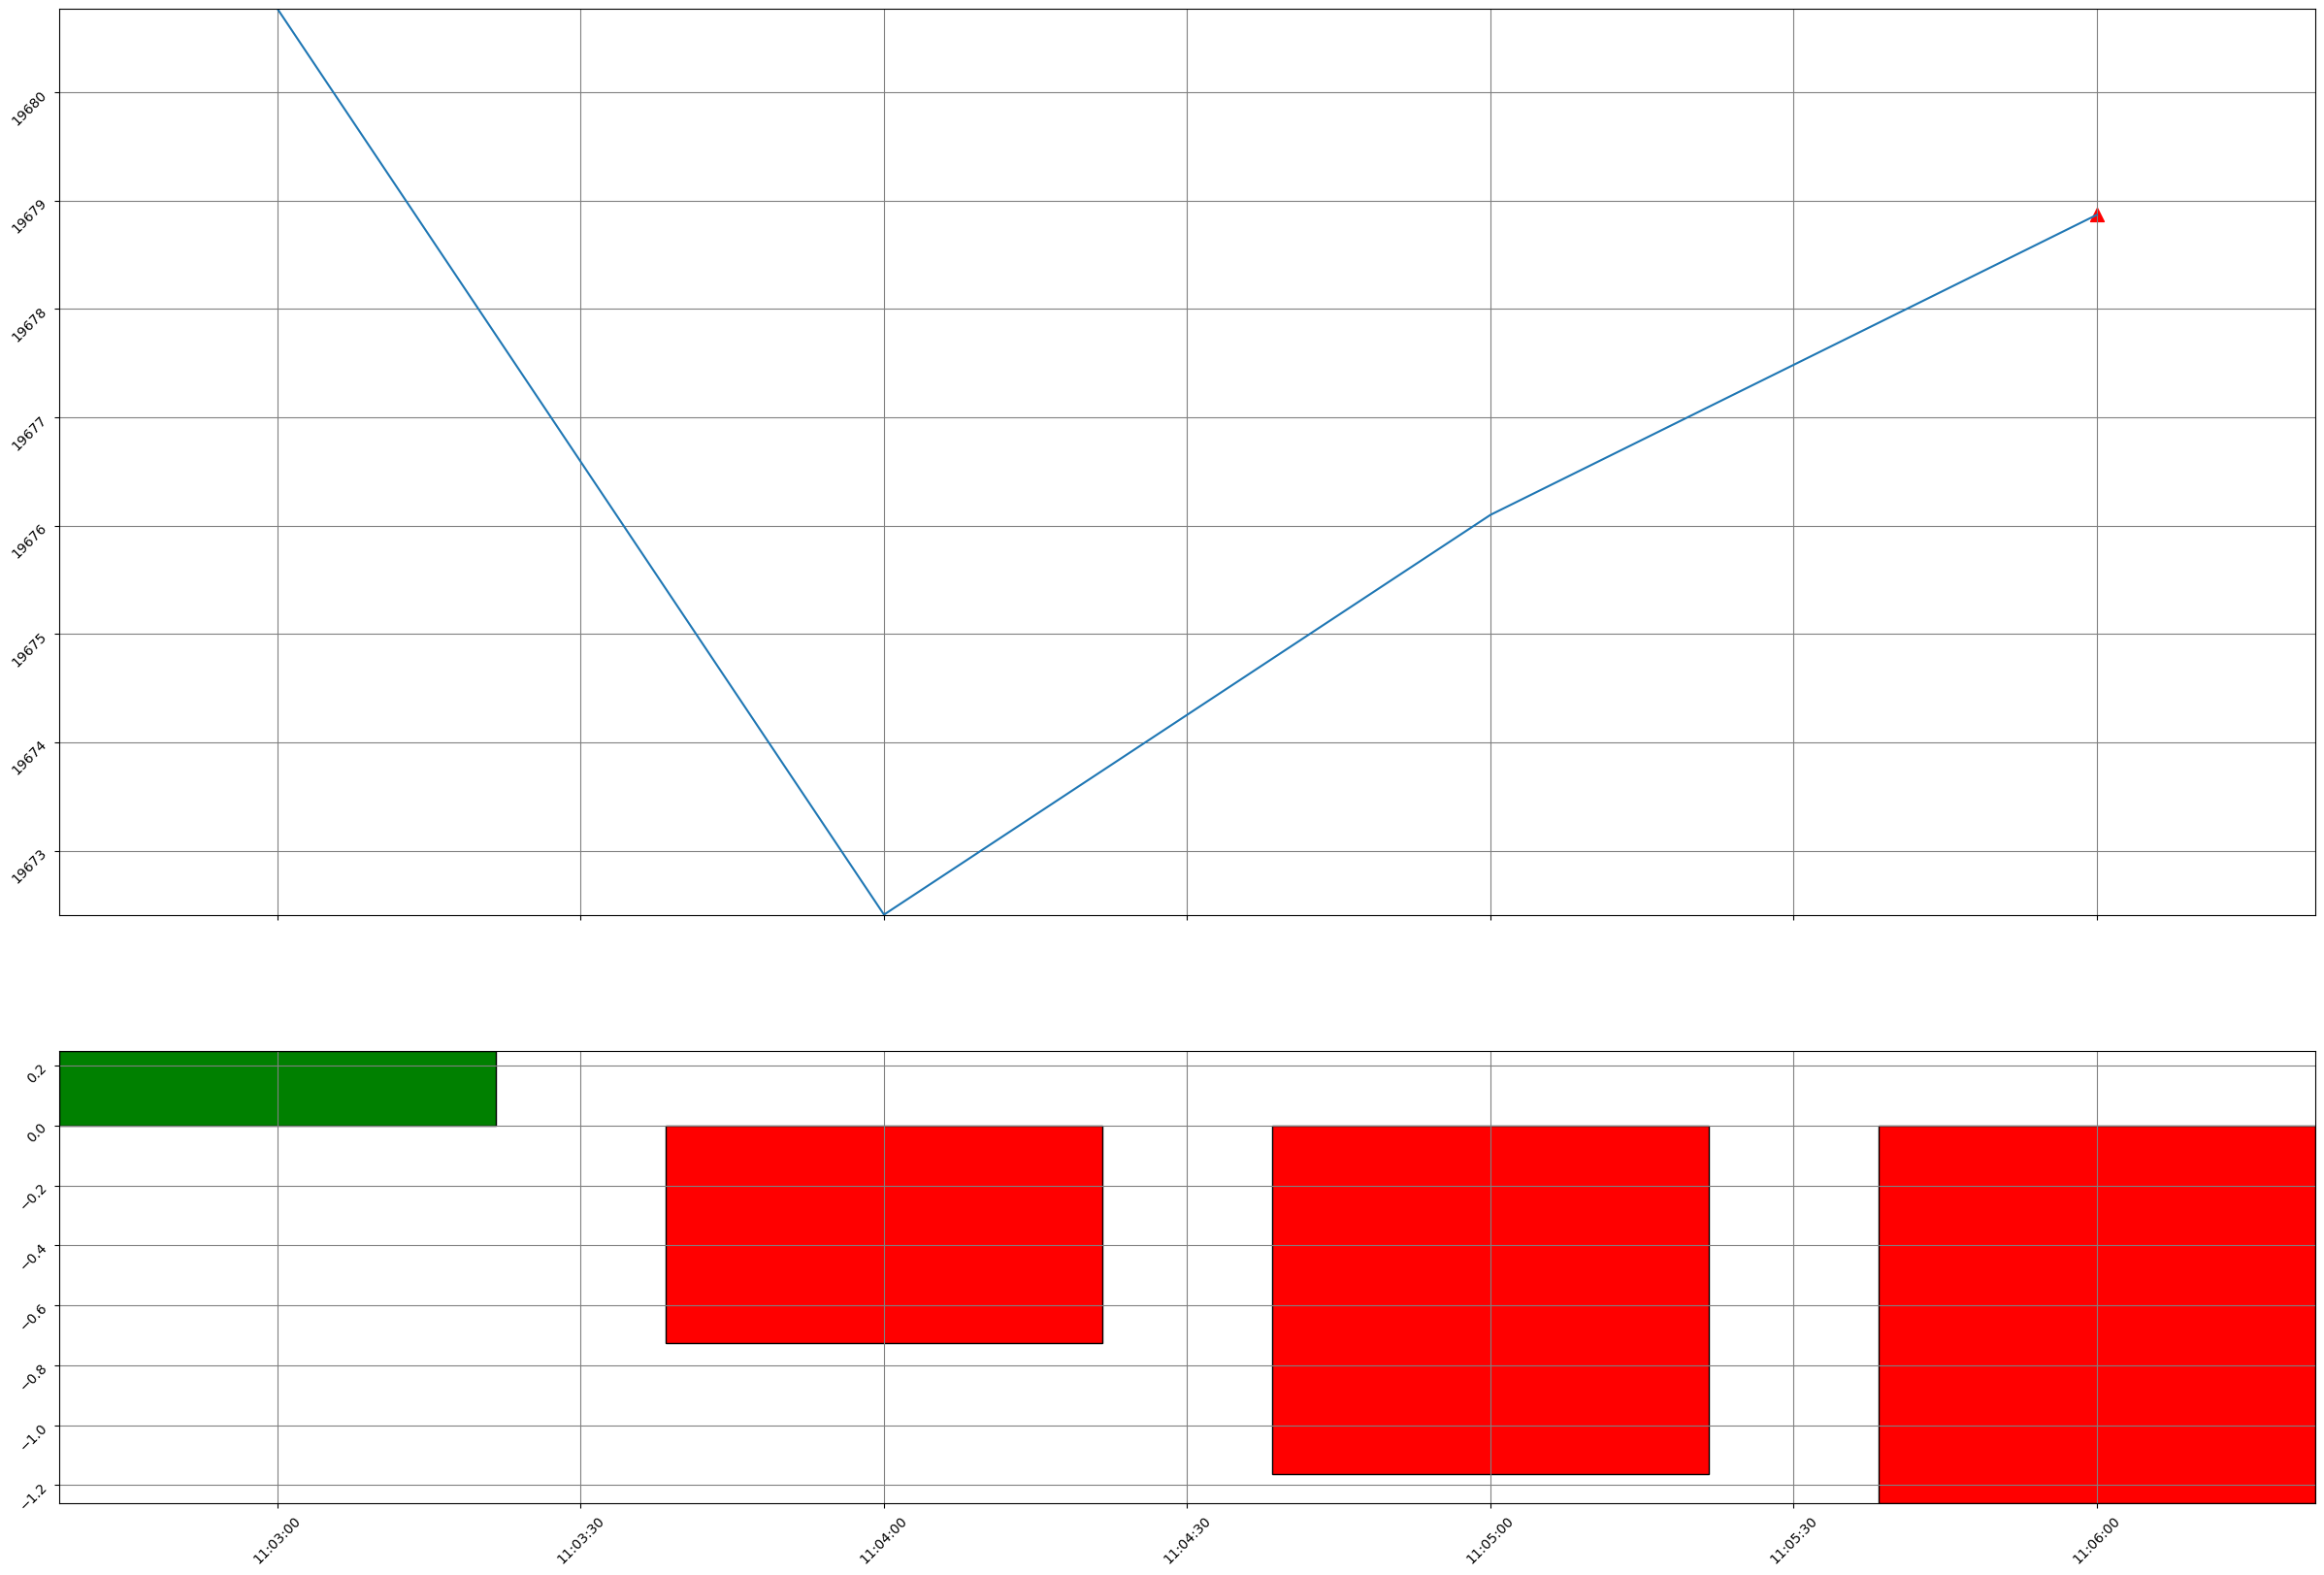

In [48]:
trader_peak_test.plot_results(width_bars=0.0005)

In [49]:
trader_peak_test.negative_peak_found

False

In [51]:
trader_peak_test.open_orders()

[]


In [52]:
trader_peak_test.client

In [53]:
trader_peak_test.data

,Open,High,Low,Close,Volume,macd_diff,macd_macd,macd_signal,Complete,position,balance_ini,balance_end,quote_units
Date,,,,,,,,,,,,,
2022-10-14 10:15:00,19671.96,19671.96,19639.91,19645.48,7.236778,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
2022-10-14 10:16:00,19649.31,19662.77,19648.19,19655.76,6.011144,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
2022-10-14 10:17:00,19655.76,19679.13,19655.19,19672.23,7.690830,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
2022-10-14 10:18:00,19671.62,19679.17,19670.95,19671.32,6.148814,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
2022-10-14 10:19:00,19671.26,19686.32,19665.36,19684.13,6.946345,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
2022-10-14 10:20:00,19683.79,19683.79,19668.68,19671.84,6.179982,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
2022-10-14 10:21:00,19671.33,19671.39,19652.18,19659.07,6.079781,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
2022-10-14 10:22:00,19659.47,19673.07,19659.35,19671.04,8.057826,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
2022-10-14 10:23:00,19673.07,19693.31,19673.07,19693.31,7.554092,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN


In [54]:
trader_peak_test.interval

'1m'

In [55]:
trader_peak_test.ema_fast

12

In [56]:
trader_peak_test.ema_signal

25

In [57]:
trader_peak_test.ema_slow

25

In [58]:
trader_peak_test.duration_minutes

20

In [59]:
trader_peak_test.profit

-101.6112

In [60]:
trader_peak_test.trade_values

[-200, 98.3888]

In [61]:
trader_peak_test

In [62]:
trader_peak_test.position

0

In [63]:
trader_peak_test.positive_peak_found

False

In [64]:
trader_peak_test.symbol

'BTCUSDT'

In [65]:
trader_peak_test.units

'0.005'

In [66]:
trader_peak_test.trades

1